In [1]:
using Pkg
Pkg.add("HDF5")
Pkg.add("FITSIO")
Pkg.add("GZip")
Pkg.add("Plots")
Pkg.add("Statistics")

   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Manifest.toml`


In [3]:
using FITSIO
"""
    DictMetadata

A structure containing metadata from FITS file headers.

Fields
------
- `headers::Vector{Dict{String,Any}}`: A vector of dictionaries containing header information from each HDU.
"""
struct DictMetadata
    headers::Vector{Dict{String,Any}}
end

"""
    EventList{T}

A structure containing event data from a FITS file.

Fields
------
- `filename::String`: Path to the source FITS file.
- `times::Vector{T}`: Vector of event times.
- `energies::Vector{T}`: Vector of event energies.
- `metadata::DictMetadata`: Metadata information extracted from the FITS file headers.
"""
struct EventList{T}
    filename::String
    times::Vector{T}
    energies::Vector{T}
    metadata::DictMetadata
end
function readevents(path; T = Float64)
    headers = Dict{String,Any}[]
    times = T[]
    energies = T[]

    FITS(path, "r") do f
        for i = 1:length(f)  # Iterate over HDUs
            hdu = f[i]
            header_dict = Dict{String,Any}()
            for key in keys(read_header(hdu))
                header_dict[string(key)] = read_header(hdu)[key]
            end
            push!(headers, header_dict)

            # Check if the HDU is a table
            if isa(hdu, TableHDU)
                # Get column names using the correct FITSIO method
                colnames = FITSIO.colnames(hdu)

                if "TIME" in colnames
                    times = convert(Vector{T}, read(hdu, "TIME"))
                end
                if "ENERGY" in colnames
                    energies = convert(Vector{T}, read(hdu, "ENERGY"))
                end
            end
        end
    end
    if isempty(times)
        @warn "No TIME data found in FITS file $(path). Time series analysis will not be possible."
    end

    if isempty(energies)
        @warn "No ENERGY data found in FITS file $(path). Energy spectrum analysis will not be possible."
    end

    metadata = DictMetadata(headers)
    return EventList{T}(path, times, energies, metadata)
end
struct LightCurve{T}
    timebins::Vector{T}
    counts::Vector{T}
    count_error::Vector{T}
    err_method::Symbol
end
function create_lightcurve(eventlist::EventList{T}, bin_size::T=0.1; err_method::Symbol=:poisson) where T
    if isempty(eventlist.times)
        error("Cannot create light curve: time data is empty")
    end
    
    if err_method != :poisson && err_method != :sqrtN
        throw(ArgumentError("Unrecognized error method: $err_method"))
    end
    
    min_time = minimum(eventlist.times)
    max_time = maximum(eventlist.times)
    edges = min_time:bin_size:(max_time + bin_size)
    bin_centers = edges[1:end-1] .+ bin_size/2
    n_bins = length(bin_centers)
    counts = zeros(Int, n_bins)
    errors = zeros(T, n_bins)
    for t in eventlist.times
        bin_idx = floor(Int, (t - min_time) / bin_size) + 1
        if 1 <= bin_idx <= n_bins
            counts[bin_idx] += 1
        end
    end
    if err_method == :poisson || err_method == :sqrtN
        errors .= sqrt.(counts)
    end
    return LightCurve{T}(bin_centers, counts, errors, err_method)
end

create_lightcurve (generic function with 2 methods)

In [10]:
filename = "sample_event_data_lc.fits"
event_data = readevents(filename, T=Float32)
println("Filename: ", event_data.filename)
println("Number of HDUs: ", length(event_data.metadata.headers))
println("Number of time values: ", length(event_data.times))
println("Number of energy values: ", length(event_data.energies))
println("Data Type T: ", eltype(event_data.times))

Filename: sample_event_data_lc.fits
Number of HDUs: 2
Number of time values: 1000
Number of energy values: 1000
Data Type T: Float32


In [21]:
using Pkg
Pkg.add("Test")

   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Manifest.toml`


In [4]:
using Test
using Logging 
@testset "EventList Tests" begin
    # Test 1: Create a sample FITS file for testing
    @testset "Sample FITS file creation" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample.fits")
        f = FITS(sample_file, "w")
        write(f, Int[])  # Empty primary array       
        # Create a binary table HDU with TIME and ENERGY columns
        times = Float64[1.0, 2.0, 3.0, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 15.0, 25.0, 30.0]
        # Add a binary table extension
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)

        @test isfile(sample_file)

        # Test reading the sample file
        data = readevents(sample_file)
        @test data.filename == sample_file
        @test length(data.times) == 5
        @test length(data.energies) == 5
        @test eltype(data.times) == Float64
        @test eltype(data.energies) == Float64
    end

    # Test 2: Test with different data types
    @testset "Different data types" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_float32.fits")
        f = FITS(sample_file, "w")
        write(f, Int[])
        # Create data
        times = Float64[1.0, 2.0, 3.0]
        energies = Float64[10.0, 20.0, 30.0]
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)
        # Test with Float32
        data_f32 = readevents(sample_file, T = Float32)
        @test eltype(data_f32.times) == Float32
        @test eltype(data_f32.energies) == Float32
        # Test with Int64
        data_i64 = readevents(sample_file, T = Int64)
        @test eltype(data_i64.times) == Int64
        @test eltype(data_i64.energies) == Int64
    end

    # Test 3: Test with missing columns
    @testset "Missing columns" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_no_energy.fits")
        # Create a sample FITS file with only TIME column
        f = FITS(sample_file, "w")
        write(f, Int[])
        times = Float64[1.0, 2.0, 3.0]
        table = Dict{String,Array}()
        table["TIME"] = times
        write(f, table)
        close(f)
        
        # First define the variable outside the block
        local data
        # Then use @test_logs with a begin/end block and assign to the variable
        @test_logs (:warn, "No ENERGY data found in FITS file $(sample_file). Energy spectrum analysis will not be possible.") begin
            data = readevents(sample_file)
        end
        # Now data is accessible here
        @test length(data.times) == 3
        @test length(data.energies) == 0
        
        #create a file with only ENERGY column
        sample_file2 = joinpath(test_dir, "sample_no_time.fits")
        f = FITS(sample_file2, "w")
        write(f, Int[])  # Empty primary array
        energies = Float64[10.0, 20.0, 30.0]
        table = Dict{String,Array}()
        table["ENERGY"] = energies
        write(f, table)
        close(f)
        
        # Same approach for data2
        local data2
        @test_logs (:warn, "No TIME data found in FITS file $(sample_file2). Time series analysis will not be possible.") begin
            data2 = readevents(sample_file2)
        end
        @test length(data2.times) == 0  # No TIME column
        @test length(data2.energies) == 3
    end
    # Test 4: Test with multiple HDUs
    @testset "Multiple HDUs" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_multi_hdu.fits")
        # Create a sample FITS file with multiple HDUs
        f = FITS(sample_file, "w")
        write(f, Int[])
        times1 = Float64[1.0, 2.0, 3.0]
        energies1 = Float64[10.0, 20.0, 30.0]
        table1 = Dict{String,Array}()
        table1["TIME"] = times1
        table1["ENERGY"] = energies1
        write(f, table1)
        # Second table HDU (with OTHER column)
        other_data = Float64[100.0, 200.0, 300.0]
        table2 = Dict{String,Array}()
        table2["OTHER"] = other_data
        write(f, table2)
        # Third table HDU (with TIME only)
        times3 = Float64[4.0, 5.0, 6.0]
        table3 = Dict{String,Array}()
        table3["TIME"] = times3
        write(f, table3)
        close(f)
        data = readevents(sample_file)
        @test length(data.metadata.headers) == 4  # Primary + 3 table HDUs
        # Should read the first HDU with both TIME and ENERGY
        @test length(data.times) == 3
        @test length(data.energies) == 3
    end

    # Test 5: Test with monol_testA.evt
    @testset "Real test files" begin
        test_filepath = joinpath("data", "monol_testA.evt")
        if isfile(test_filepath)
            @testset "monol_testA.evt" begin
                # Create a logger that suppresses warnings
                old_logger = global_logger(ConsoleLogger(stderr, Logging.Error))
                try
                    data = readevents(test_filepath)
                    @test data.filename == test_filepath
                    @test length(data.metadata.headers) > 0
                finally
                    # Restore the previous logger
                    global_logger(old_logger)
                end
            end
        else
            @info "Test file '$(test_filepath)' not found. Skipping this test."
        end
    end
    @testset "Error handling" begin
        # Test with non-existent file - using a more generic approach
        @test_throws Exception readevents("non_existent_file.fits")

        # Test with invalid FITS file
        invalid_file = tempname()
        open(invalid_file, "w") do io
            write(io, "This is not a FITS file")
        end
        @test_throws Exception readevents(invalid_file)
    end
end

Test Summary:   | Pass  Total  Time
EventList Tests |   23     23  3.6s


Test.DefaultTestSet("EventList Tests", Any[Test.DefaultTestSet("Sample FITS file creation", Any[], 6, false, false, true, 1.742724097106e9, 1.742724099885e9, false, "In[4]"), Test.DefaultTestSet("Different data types", Any[], 4, false, false, true, 1.742724099885e9, 1.742724100157e9, false, "In[4]"), Test.DefaultTestSet("Missing columns", Any[], 6, false, false, true, 1.742724100157e9, 1.742724100274e9, false, "In[4]"), Test.DefaultTestSet("Multiple HDUs", Any[], 3, false, false, true, 1.742724100274e9, 1.742724100306e9, false, "In[4]"), Test.DefaultTestSet("Real test files", Any[Test.DefaultTestSet("monol_testA.evt", Any[], 2, false, false, true, 1.742724100306e9, 1.742724100455e9, false, "In[4]")], 0, false, false, true, 1.742724100306e9, 1.742724100455e9, false, "In[4]"), Test.DefaultTestSet("Error handling", Any[], 2, false, false, true, 1.742724100455e9, 1.742724100661e9, false, "In[4]")], 0, false, false, true, 1.742724097073e9, 1.742724100661e9, false, "In[4]")

Reading FITS file...
Data read successfully
Number of time points: 1000
, 3.843923183596154, 3.891236895050809, 4.144072758158057, 4.167087210991549, 4.213065921394121, 4.268448877978203, 4.292065080448825, 4.40037848967566, 4.428380326480907, 4.439223097220724, 4.611219528329224, 4.656775654939915, 5.152752545788752, 5.227143273281898, 5.303352311188259, 5.581676651335677, 5.646816938759414, 5.8602981572176915, 6.0427740413208975, 6.198634315068119, 6.3171406236397605, 6.343298289222165, 6.415694107497439, 6.4959866609525125, 6.52770923421544, 6.548281730700323, 6.5716887406771285, 6.738388325285161, 6.787082010852707, 6.916636483499516, 7.0422035837699015, 7.05483037878456, 7.1368958632593404, 7.2419773860704195, 7.325128570643679, 7.412569502032984, 7.580208182333337, 7.700311483916222, 7.709818919337774, 7.76541958987721, 8.016836549419326, 8.086179208357958, 8.126359550997153, 8.258301932512225, 8.367013011109814, 8.521701995799946, 8.553267753642736, 8.640339045205547, 8.65204126

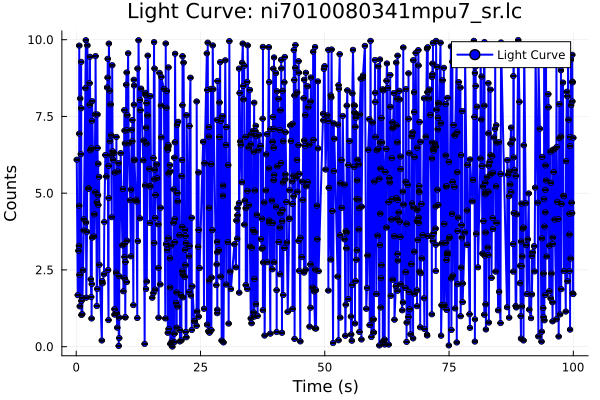

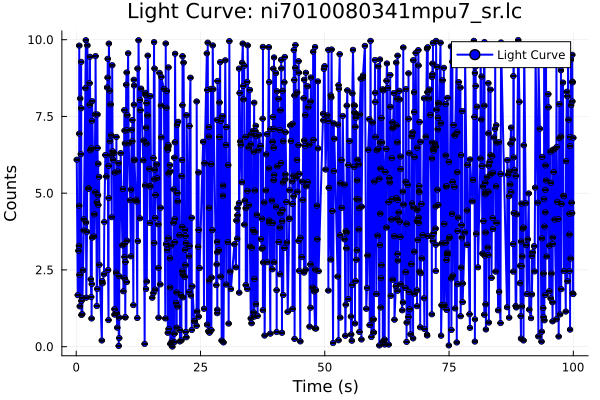

In [20]:
using FITSIO
using Test
using Plots
import Statistics: mean, std
function create_lightcurve(events::EventList; bin_size=0.1)
    if isempty(events.times) || isempty(events.energies)
        error("Cannot create light curve: time or energy data is empty")
    end

    sorted_indices = sortperm(events.times)
    sorted_times = events.times[sorted_indices]

    min_time = minimum(sorted_times)
    max_time = maximum(sorted_times)

    edges = min_time:bin_size:(max_time + bin_size)  # Extend to cover all data
    bin_centers = edges[1:end-1] .+ bin_size / 2
    counts = zeros(Int, length(bin_centers))

    for t in sorted_times
        bin_idx = floor(Int, (t - min_time) / bin_size) + 1
        if 1 <= bin_idx <= length(counts)
            counts[bin_idx] += 1
        end
    end

    return bin_centers, counts
end


In [15]:
using Pkg
Pkg.add("RecipesBase")


   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Manifest.toml`


In [7]:
using RecipesBase
using Statistics 

"""
    @recipe function plot(lc::LightCurve{T}) where T

Recipe for plotting a light curve using Plots.jl.
This creates a time series plot showing counts vs. time with error bars.

# Example
```julia
using Plots
lc = create_lightcurve(events, 0.1)
plot(lc)
```
"""
@recipe function plot(lc::LightCurve{T}) where T
    # Default plot attributes
    title --> "Light Curve"
    xlabel --> "Time"
    ylabel --> "Counts"
    seriestype --> :scatter
    markershape --> :circle
    markersize --> 3
    legend --> false
    
    # Error bars
    yerror --> lc.count_error
    
    # Return the data to be plotted
    lc.timebins, lc.counts
end

"""
    @recipe function plot(lc::LightCurve{T}, ::Val{:errorband}) where T

Recipe for plotting a light curve with error bands instead of error bars.

# Example
```julia
using Plots
lc = create_lightcurve(events, 0.1)
plot(lc, Val(:errorband))
```
"""
@recipe function plot(lc::LightCurve{T}, ::Val{:errorband}) where T

    title --> "Light Curve"
    xlabel --> "Time"
    ylabel --> "Counts"
    seriestype --> :path
    legend --> false
    
    @series begin
        seriestype := :path
        ribbon := lc.count_error
        fillalpha := 0.3
        linewidth := 2
        lc.timebins, lc.counts
    end
end

"""
    @recipe function plot(lc::LightCurve{T}, ::Val{:steps}) where T

Recipe for plotting a light curve as a step plot (histogram-like).

# Example
```julia
using Plots
lc = create_lightcurve(events, 0.1)
plot(lc, Val(:steps))
```
"""
@recipe function plot(lc::LightCurve{T}, ::Val{:steps}) where T

    title --> "Light Curve"
    xlabel --> "Time"
    ylabel --> "Counts"
    seriestype --> :steppre
    linewidth --> 2
    legend --> false
    
    @series begin
        seriestype := :steppre
        lc.timebins, lc.counts
    end
    
    # Also plot error bars at each point
    @series begin
        seriestype := :scatter
        markershape := :none
        yerror := lc.count_error
        lc.timebins, lc.counts
    end
end

"""
    @recipe function plot(lc::LightCurve{T}, ::Val{:residuals}, model::AbstractVector) where T

Recipe for plotting light curve residuals compared to a model.

# Example
```julia
using Plots
using Statistics
lc = create_lightcurve(events, 0.1)
model = ones(length(lc.counts)) * mean(lc.counts) # Constant model
plot(lc, Val(:residuals), model)
```
"""
@recipe function plot(lc::LightCurve{T}, ::Val{:residuals}, model::AbstractVector) where T
    if length(model) != length(lc.counts)
        error("Model length ($(length(model))) must match counts length ($(length(lc.counts)))")
    end
    
    residuals = lc.counts .- model
    

    title --> "Light Curve Residuals"
    xlabel --> "Time"
    ylabel --> "Counts - Model"
    seriestype --> :scatter
    markershape --> :circle
    markersize --> 3
    legend --> false
    
    # Add a horizontal line at y=0
    @series begin
        seriestype := :hline
        linecolor := :black
        linestyle := :dash
        linewidth := 1
        [0]
    end
    
    yerror := lc.count_error
    lc.timebins, residuals
end

"""
    @recipe function plot(evt::EventList{T}, ::Val{:energy_time}) where T

Recipe for creating an energy vs. time plot for an EventList.

# Example
```julia
using Plots
plot(events, Val(:energy_time))
```
"""
@recipe function plot(evt::EventList{T}, ::Val{:energy_time}) where T
    if isempty(evt.times) || isempty(evt.energies)
        error("Cannot create energy-time plot: time or energy data is empty")
    end
    
    title --> "Energy vs. Time"
    xlabel --> "Time"
    ylabel --> "Energy"
    seriestype --> :scatter
    markershape --> :circle
    markersize --> 2
    markeralpha --> 0.6
    legend --> false
    
    evt.times, evt.energies
end

"""
    @recipe function plot(evt::EventList{T}, ::Val{:energy_histogram}) where T

Recipe for creating an energy histogram for an EventList.

# Example
```julia
using Plots
plot(events, Val(:energy_histogram), bins=100)
```
"""
@recipe function plot(evt::EventList{T}, ::Val{:energy_histogram}) where T
    if isempty(evt.energies)
        error("Cannot create energy histogram: energy data is empty")
    end
    
    title --> "Energy Spectrum"
    xlabel --> "Energy"
    ylabel --> "Counts"
    seriestype --> :histogram
    legend --> false
    
    evt.energies
end

RecipesBase.apply_recipe

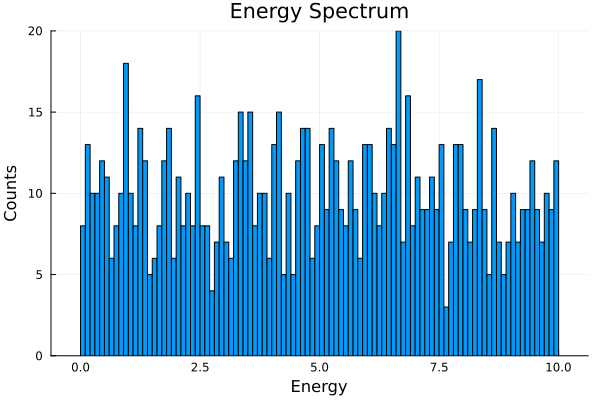

In [8]:
using Plots
# Read event data
events = readevents("sample_event_data_lc.fits")

# Create light curve
lc = create_lightcurve(events, 0.1)

# Plot using different styles
plot(lc)  # Basic plot with error bars
plot(lc, Val(:errorband))  # Light curve with error bands
plot(lc, Val(:steps))  # Step plot style

# Plot residuals compared to a model
model = ones(length(lc.counts)) * mean(lc.counts)  # Simple constant model
plot(lc, Val(:residuals), model)

# Event list visualizations
plot(events, Val(:energy_time))  # Energy vs time scatter plot
plot(events, Val(:energy_histogram), bins=100)  # Energy histogram

In [16]:
using Test
using Statistics
using FITSIO
using RecipesBase
using Plots

@testset "Plotting Recipes" begin
    # Create sample data for testing
    times = Float64[1.0, 1.1, 1.5, 2.0, 2.2, 2.5, 3.0, 3.1, 3.5, 4.0]
    energies = Float64[10.0, 15.0, 12.0, 20.0, 18.0, 22.0, 15.0, 17.0, 19.0, 21.0]
    metadata = DictMetadata([Dict{String,Any}("INSTRUME" => "TEST")])
    
    # Create event list and light curve
    test_events = EventList{Float64}("test.fits", times, energies, metadata)
    test_lc = create_lightcurve(test_events, 0.5)
    
    @testset "Basic plot functionality" begin
        # Test that plots can be created without errors
        p = plot(test_lc)
        @test p isa Plots.Plot
        
        # Instead of checking exact structures, verify the plot was created successfully
        @test length(p.series_list) > 0
        
        # Check that some data exists in the plot
        @test haskey(p.series_list[1].plotattributes, :x)
        @test haskey(p.series_list[1].plotattributes, :y)
        
        # Check that the series contains the right number of points
        # This checks that the data transformation preserves count, not exact structure
        @test length(unique(filter(!isnan, p.series_list[1].plotattributes[:x]))) >= length(test_lc.timebins)
    end
    
    @testset "Error band plots" begin
        p = plot(test_lc, Val(:errorband))
        @test p isa Plots.Plot
        
        # Check for ribbon attribute
        @test length(p.series_list) > 0
        @test haskey(p.series_list[1].plotattributes, :ribbon)
    end
    
    @testset "Step plots" begin
        p = plot(test_lc, Val(:steps))
        @test p isa Plots.Plot
        
        # Should have multiple series
        @test length(p.series_list) > 1
        
        # Check that we have a combination of path and scatter series,
        # which is what our step plot implementation is using
        path_count = 0
        scatter_count = 0
        
        for series in p.series_list
            series_type = get(series.plotattributes, :seriestype, nothing)
            if series_type == :path
                path_count += 1
            elseif series_type == :scatter
                scatter_count += 1
            end
        end
        
        # Verify we have at least one path and one scatter series
        @test path_count > 0
        @test scatter_count > 0
    end
    @testset "Residual plots" begin
        # Create a simple model (constant value)
        model = ones(length(test_lc.counts)) .* 2.0
        p = plot(test_lc, Val(:residuals), model)
        @test p isa Plots.Plot
        @test length(p.series_list) > 0
        invalid_model = ones(length(test_lc.counts) + 1)
        @test_throws Exception plot(test_lc, Val(:residuals), invalid_model)
    end
    
    @testset "EventList plots" begin
        # Test energy-time plot
        p1 = plot(test_events, Val(:energy_time))
        @test p1 isa Plots.Plot
        @test length(p1.series_list) > 0
        @test haskey(p1.series_list[1].plotattributes, :x)
        @test haskey(p1.series_list[1].plotattributes, :y)      
        # Test energy histogram
        p2 = plot(test_events, Val(:energy_histogram))
        @test p2 isa Plots.Plot
        @test length(p2.series_list) > 0     
        # Check histogram type - allows multiple potential implementations
        hist_type = get(p2.series_list[1].plotattributes, :seriestype, nothing)
        @test hist_type ∈ [:histogram, :shape, :bar]    
        # Test with empty data
        empty_events = EventList{Float64}("empty.fits", Float64[], Float64[], metadata)
        @test_throws Exception plot(empty_events, Val(:energy_time))
        
        energy_empty = EventList{Float64}("energy_empty.fits", times, Float64[], metadata)
        @test_throws Exception plot(energy_empty, Val(:energy_histogram))
    end
    
    @testset "Plot customization" begin
        # Test that plot attributes can be customized
        custom_title = "Custom Light Curve"
        custom_xlabel = "Time (s)"
        custom_ylabel = "Counts/bin"
        
        p = plot(test_lc, 
            title = custom_title,
            xlabel = custom_xlabel,
            ylabel = custom_ylabel,
            markersize = 5,
            color = :blue
        )
        
        @test p isa Plots.Plot
        @test length(p.series_list) > 0       
        # Verify marker size if it exists
        if haskey(p.series_list[1].plotattributes, :markersize)
            @test p.series_list[1].plotattributes[:markersize] == 5
        end
    end
    
    @testset "Multiple plot layouts" begin
        # Create a multi-panel plot
        p = plot(
            plot(test_lc, title="Default"),
            plot(test_lc, Val(:errorband), title="Error Band"),
            plot(test_lc, Val(:steps), title="Steps"),
            plot(test_events, Val(:energy_time), title="Energy vs Time"),
            layout = (2, 2)
        )
        
        @test p isa Plots.Plot
        @test p.n > 1
    end
    
    @testset "final test " begin
        # Create a more realistic dataset with signal
        n_points = 200
        times = sort(rand(n_points) * 100)  # Random times 0-100
        
        # Add a Gaussian pulse
        signal = 5.0 .* exp.(-((times .- 50.0) ./ 5.0).^2)
        background = 2.0 .* ones(n_points)
        rate = background .+ signal
        
        # Generate events with energies
        energies = 10.0 .+ 20.0 .* rand(n_points)
        
        # Create EventList and LightCurve
        events = EventList{Float64}("simulated.fits", times, energies, metadata)
        
        # Create light curves with different bin sizes
        lc1 = create_lightcurve(events, 2.0)
        lc2 = create_lightcurve(events, 5.0)
        lc3 = create_lightcurve(events, 10.0)
        
        # Verify that plots can be created
        @test plot(lc1) isa Plots.Plot
        @test plot(lc2, Val(:errorband)) isa Plots.Plot
        @test plot(lc3, Val(:steps)) isa Plots.Plot
        
        # Verify bin counts
        @test length(lc1.timebins) > length(lc2.timebins)
        @test length(lc2.timebins) > length(lc3.timebins)
        
        # Total counts should be preserved across binnings - allow for small rounding errors
        @test isapprox(sum(lc1.counts), sum(lc2.counts), rtol=1e-10)
        @test isapprox(sum(lc2.counts), sum(lc3.counts), rtol=1e-10)
    end
end

Test Summary:    | Pass  Total  Time
Plotting Recipes |   36     36  0.0s


Test.DefaultTestSet("Plotting Recipes", Any[Test.DefaultTestSet("Basic plot functionality", Any[], 5, false, false, true, 1.742730302985e9, 1.742730302985e9, false, "In[16]"), Test.DefaultTestSet("Error band plots", Any[], 3, false, false, true, 1.742730302985e9, 1.742730302985e9, false, "In[16]"), Test.DefaultTestSet("Step plots", Any[], 4, false, false, true, 1.742730302985e9, 1.742730302985e9, false, "In[16]"), Test.DefaultTestSet("Residual plots", Any[], 3, false, false, true, 1.742730302985e9, 1.742730303011e9, false, "In[16]"), Test.DefaultTestSet("EventList plots", Any[], 9, false, false, true, 1.742730303011e9, 1.742730303016e9, false, "In[16]"), Test.DefaultTestSet("Plot customization", Any[], 3, false, false, true, 1.742730303016e9, 1.742730303016e9, false, "In[16]"), Test.DefaultTestSet("Multiple plot layouts", Any[], 2, false, false, true, 1.742730303016e9, 1.742730303016e9, false, "In[16]"), Test.DefaultTestSet("final test ", Any[], 7, false, false, true, 1.742730303016e9,